In [8]:
# Import required libraries
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Read in the insurance dataset
df = pd.read_csv("/content/drive/MyDrive/TSLA.csv")
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.000000,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.420000,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.920000,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.100000,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.000000,15.830000,16.110001,16.110001,6866900
...,...,...,...,...,...,...,...
2411,2020-01-28,568.489990,576.809998,558.080017,566.900024,566.900024,11788500
2412,2020-01-29,575.690002,589.799988,567.429993,580.989990,580.989990,17801500
2413,2020-01-30,632.419983,650.880005,618.000000,640.809998,640.809998,29005700
2414,2020-01-31,640.000000,653.000000,632.520020,650.570007,650.570007,15719300


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2416 entries, 0 to 2415
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2416 non-null   object 
 1   Open       2416 non-null   float64
 2   High       2416 non-null   float64
 3   Low        2416 non-null   float64
 4   Close      2416 non-null   float64
 5   Adj Close  2416 non-null   float64
 6   Volume     2416 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 132.2+ KB


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Load data
data = pd.read_csv("/content/drive/MyDrive/TSLA.csv")
data['Date'] = pd.to_datetime(data['Date'])
data.set_index('Date', inplace=True)

# Preprocess data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# Train-test split for time series data
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

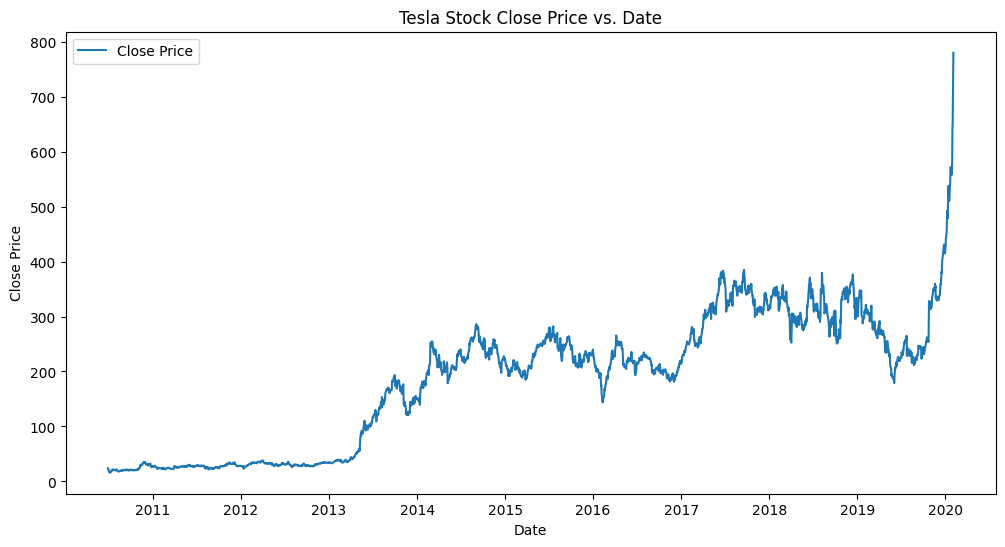

In [7]:
# Plot the price vs. date
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Close'], label='Close Price')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.title('Tesla Stock Close Price vs. Date')
plt.legend()
plt.show()

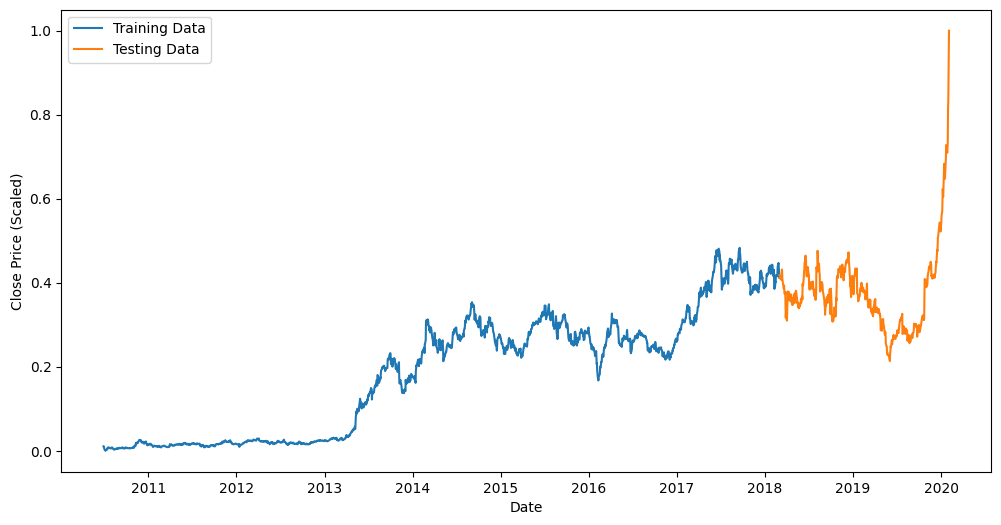

In [2]:
# Plot the train and test data
plt.figure(figsize=(12, 6))
plt.plot(data.index[:train_size], train_data, label='Training Data')
plt.plot(data.index[train_size:], test_data, label='Testing Data')
plt.xlabel('Date')
plt.ylabel('Close Price (Scaled)')
plt.legend()
plt.show()

In [3]:
# Create data windows for LSTM model
def create_windows(data, window_size):
    X = []
    y = []

    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i, 0])
        y.append(data[i, 0])

    return np.array(X), np.array(y)

window_size = 60
X_train, y_train = create_windows(train_data, window_size)
X_test, y_test = create_windows(test_data, window_size)

# Reshape data for LSTM model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [4]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test))

Epoch 1/50
30/30 [==============================] - 6s 79ms/step - loss: 0.0060 - val_loss: 0.0025
Epoch 2/50
30/30 [==============================] - 2s 53ms/step - loss: 3.9426e-04 - val_loss: 0.0016
Epoch 3/50
30/30 [==============================] - 2s 54ms/step - loss: 2.3800e-04 - val_loss: 0.0014
Epoch 4/50
30/30 [==============================] - 2s 54ms/step - loss: 2.5236e-04 - val_loss: 0.0014
Epoch 5/50
30/30 [==============================] - 2s 56ms/step - loss: 2.2443e-04 - val_loss: 0.0014
Epoch 6/50
30/30 [==============================] - 2s 83ms/step - loss: 2.1618e-04 - val_loss: 0.0013
Epoch 7/50
30/30 [==============================] - 2s 59ms/step - loss: 2.1073e-04 - val_loss: 0.0013
Epoch 8/50
30/30 [==============================] - 2s 54ms/step - loss: 2.1044e-04 - val_loss: 0.0012
Epoch 9/50
30/30 [==============================] - 2s 51ms/step - loss: 1.9915e-04 - val_loss: 0.0014
Epoch 10/50
30/30 [==============================] - 2s 55ms/step - loss: 1.9

In [5]:
def predict_price_on_future_date(model, data, date_to_predict, window_size, scaler):
    # Get the last window_size days of the data
    input_data = data[-window_size:]
    
    # Reshape and scale the input_data
    input_data = scaler.transform(input_data)
    input_data = input_data.reshape(1, window_size, 1)
    
    # Make the prediction
    predicted_price = model.predict(input_data)
    
    # Inverse transform the prediction to get the actual price
    predicted_price = scaler.inverse_transform(predicted_price)
    
    return predicted_price[0][0]

# Example usage
from datetime import datetime, timedelta

date_to_predict = datetime(2021, 1, 1)
window_size = 60

predicted_price = predict_price_on_future_date(model, data['Close'].values.reshape(-1, 1), date_to_predict, window_size, scaler)
print(f"Predicted price for {date_to_predict}: {predicted_price}")


1/1 [==============================] - 1s 1s/step
Predicted price for 2021-01-01 00:00:00: 663.2526245117188


In [6]:
def predict_price_for_next_days(model, data, days_to_predict, window_size, scaler):
    predictions = []

    for _ in range(days_to_predict):
        # Get the last window_size days of the data
        input_data = data[-window_size:]

        # Reshape and scale the input_data
        input_data = scaler.transform(input_data)
        input_data = input_data.reshape(1, window_size, 1)

        # Make the prediction
        predicted_price = model.predict(input_data)

        # Inverse transform the prediction to get the actual price
        predicted_price = scaler.inverse_transform(predicted_price)

        # Append the predicted price to the data
        data = np.append(data, predicted_price, axis=0)

        # Save the predicted price
        predictions.append(predicted_price[0][0])

    return predictions

# Example usage
days_to_predict = 7
window_size = 60

predicted_prices = predict_price_for_next_days(model, data['Close'].values.reshape(-1, 1), days_to_predict, window_size, scaler)
print(f"Predicted prices for the next {days_to_predict} days: {predicted_prices}")


1/1 [==============================] - 0s 57ms/step
Predicted prices for the next 7 days: [663.2526, 683.9635, 691.3241, 691.2868, 686.71155, 679.1357, 669.53284]
